In [2]:
import os
import tensorflow as tf
from keras import models
from keras import layers
from keras import Sequential
from datetime import datetime
from PIL import Image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import mlflow
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score


In [3]:
dataset_name = "private_combined"
batch_size = 64

In [4]:
# Load the dataset

image_size = (255, 255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_name,
    validation_split=0.2,
    subset="training",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_name,
    validation_split=0.2,
    subset="validation",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


Found 2791 files belonging to 3 classes.
Using 2233 files for training.
Found 2791 files belonging to 3 classes.
Using 558 files for validation.


In [5]:
# Obtain the number of samples
num_train_samples = 0
for images, labels in train_ds:
    num_train_samples += images.shape[0]

num_val_samples = 0
for images, labels in val_ds:
    num_val_samples += images.shape[0]




In [6]:
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)


Number of training samples: 2233
Number of validation samples: 558


In [7]:
imput = (255,255,3)

In [8]:
base_model = EfficientNetB5(include_top = False ,weights='imagenet', pooling='avg')

#todo introduce a layer of data augmentation 

# Introduce a layer of data augmentation
data_augmentation = Sequential([
   preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),    
])



# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 10 layers in the base model for fine-tuning

for layer in base_model.layers[-10:]:
    layer.trainable = True

#Capa de entradas. No se si eficientnet ya espera 225x225 o es 224 x 224. En realidad la efficient net ya tiene un parametro de input shape...
# Capa de entradas

entradas = layers.Input((255, 255, 3))

# Apply data augmentation to the input images
x = data_augmentation(entradas)


# Pass the augmented images through the base model
x = base_model(x)


# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(3, activation='softmax')(x)

modelo = Model(inputs = entradas, outputs = salidas)

modelo.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
modelo.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 255, 255, 3)       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 29,564,154
Trainable params: 4,073,475
Non-trainable params: 25,490,679
_________________________________________________________________


In [9]:
num_params = modelo.count_params()
print("Number of parameters:", num_params)



Number of parameters: 29564154


In [10]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'


# Callbacks

In [11]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath_model,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_freq="epoch",
save_best_only=True)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose = 1, )

## Para hacer un training con weights

In [13]:

# # Calculate class weights
# # class_weights = tf.class_weight.compute_class_weight('balanced', tf.unique(train_ds.labels)[0], train_ds.labels)

# # Convert class weights to dictionary
# # class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# # history = modelo.fit(
# #     train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback], class_weight=class_weights_dict
# # )

In [14]:
# Start an MLflow run
mlflow.start_run()

mlflow.set_experiment('efficientnet_project_capstone')

# Log the name of the dataset
mlflow.log_param("dataset_name", dataset_name)

# Log the number of samples in the dataset
#   mlflow.log_param("num_samples_train", num_train_samples)
#   mlflow.log_param("num_samples_train", num_val_samples)

epochs = 80
history = modelo.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)
 
# Evaluate the model
loss, accuracy = modelo.evaluate(val_ds)

#Logging


mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", batch_size)

mlflow.log_param("parameters", num_params)

mlflow.log_metric("val_loss", loss)
mlflow.log_metric("val_accuracy", accuracy)




Epoch 1/80
35/35 [==============================] - 83s 2s/step - loss: 0.9433 - accuracy: 0.5575 - val_loss: 0.7249 - val_accuracy: 0.6918


c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/80
35/35 [==============================] - 47s 1s/step - loss: 0.7504 - accuracy: 0.6677 - val_loss: 1.1140 - val_accuracy: 0.5305
Epoch 3/80
35/35 [==============================] - 47s 1s/step - loss: 0.6900 - accuracy: 0.7094 - val_loss: 0.6720 - val_accuracy: 0.7133
Epoch 4/80
35/35 [==============================] - 47s 1s/step - loss: 0.6311 - accuracy: 0.7385 - val_loss: 0.6175 - val_accuracy: 0.7384
Epoch 5/80
35/35 [==============================] - 47s 1s/step - loss: 0.5925 - accuracy: 0.7510 - val_loss: 0.6767 - val_accuracy: 0.7186
Epoch 6/80
35/35 [==============================] - 46s 1s/step - loss: 0.5863 - accuracy: 0.7506 - val_loss: 0.6593 - val_accuracy: 0.7240
Epoch 7/80
35/35 [==============================] - 46s 1s/step - loss: 0.5231 - accuracy: 0.7900 - val_loss: 0.7812 - val_accuracy: 0.7097
Epoch 8/80
35/35 [==============================] - 46s 1s/step - loss: 0.5535 - accuracy: 0.7738 - val_loss: 0.5431 - val_accuracy: 0.7724
Epoch 9/80
35/35 [==

In [15]:
#Guardo el modelo en la última epoch. Esto 
modelo.save(folder_date + '/modelo_entrenado.h5')


In [16]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [17]:
folder_date + "/accuracy.png"

'old_models/2023_06_27-07_40_49_AM/accuracy.png'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


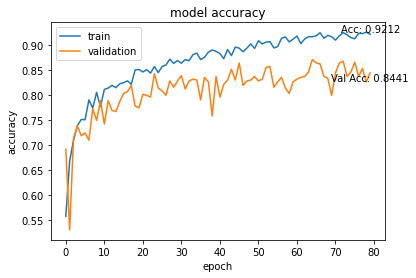

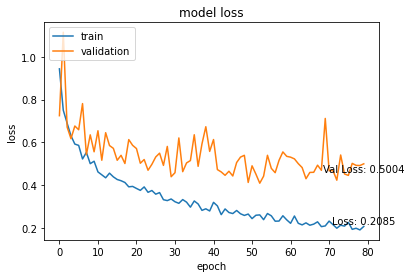

In [18]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/loss.png")
plt.show()





Preguntas, cómo puedo gestionar datos que vienen de dos distribuciones distintas?



# This is a section to evaluate the model on te test data

[0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 

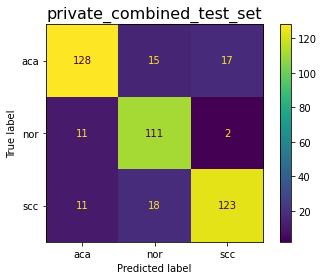

Precision: 0.8343546754533316
Recall: 0.8302752293577982
Accuracy: 0.8302752293577982


In [19]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []

label_mapping = {
    'aca': 0,
    'nor': 1,
    'scc': 2
}


directory = "private_combined_test_set"
for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)

    prediction = modelo.predict(x)
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca' in filename or 'lungaca' in filename:
        true_labels.append(0)
    elif 'scc' in filename or 'lungscc' in filename:
        true_labels.append(2)
    elif 'nor' in filename or 'lungn' in filename:
        true_labels.append(1)
   
    

    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("Accuracy", accuracy)

mlflow.end_run()



#Predice mal en las muestras de Henar. Veremos con el nuevo dataset, pero quizá haya que hacer un training con peso Opciones:

Undersample the larger distribution: randomly remove examples from the larger distribution until it matches the size of the smaller one.

Oversample the smaller distribution: randomly duplicate examples from the smaller distribution until it matches the size of the larger one.

Data augmentation: generate new examples from the smaller distribution using techniques like rotation, flipping, or zooming.

Use class weights: adjust the loss function of your CNN to assign higher weights to the smaller distribution so that it receives more emphasis during training.

Fine-tuning: you could use a pre-trained model to initialize the weights and only fine-tune the last few layers to fit the imbalanced data.

[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


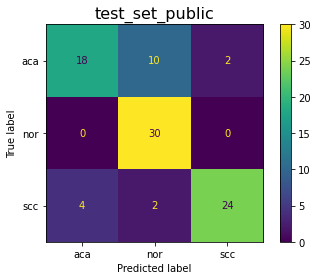

Precision: 0.8185148185148186
Recall: 0.8
Accuracy: 0.8


In [20]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []

label_mapping = {
    'aca': 0,
    'nor': 1,
    'scc': 2
}


directory = "test_set_public"
for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)

    prediction = modelo.predict(x)
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca' in filename or 'lungaca' in filename:
        true_labels.append(0)
    elif 'scc' in filename or 'lungscc' in filename:
        true_labels.append(2)
    elif 'nor' in filename or 'lungn' in filename:
        true_labels.append(1)
   
    

    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("Accuracy", accuracy)

mlflow.end_run()


